In [1]:
import xml.etree.cElementTree as ET
import urllib2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import calendar

Enable IPython to display matplotlib graphs and select style

In [2]:
%matplotlib inline
plt.style.use('ggplot')

Setup parameters

In [3]:
USER = 'banzayats'
MINDATE='2017-01-01'
MAXDATE='2017-12-31'

In [4]:
def get_gamedata(user, mindate, maxdate):
    dataframe = pd.DataFrame(columns=('Name', 'Length', 'Date', 'Location', 'Players', 'Winner'))
    API_LINK = 'https://boardgamegeek.com/xmlapi2/plays'
    page = 1
    end = False
    while not end:
        url = '{0}?username={1}&mindate={2}&maxdate={3}&page={4}'.format(API_LINK, user, mindate, maxdate, page)
        tree = ET.ElementTree(file=urllib2.urlopen(url))
        plays = tree.getroot()
        if len(plays) < 100:
            end = True
        for i,play in enumerate(plays.findall(".//play[@quantity='1']")):
            length = play.attrib['length']
            date = play.attrib['date']
            location = play.attrib['location']
            name = play[0].attrib['name'].encode("utf-8")
            players = len(play.find('players').findall('player'))
            # Getting winners
            winners = play.findall(".//player[@win='1']")
            if len(winners) > 1:
                winner = "Team"
            elif len(winners) == 0:
                winner = "No-one"
            else:
                winner = winners[0].attrib['name']
            # Writing dataframe
            pointer = i + 100 * (page - 1)
            dataframe.loc[pointer] = [name, length, date, location, players, winner]
        page += 1
    dataframe['Date'] = pd.to_datetime(dataframe['Date'])
    return dataframe

In [5]:
df = get_gamedata(USER, MINDATE, MAXDATE)
df.head()

,Name,Length,Date,Location,Players,Winner
0,Roll for the Galaxy,60,2017-12-26,Home,2,Vadim
1,7 Wonders Duel,40,2017-12-24,Home,2,Vadim
2,Mysterium,30,2017-12-24,Kirill's home,3,No-one
3,Mysterium,60,2017-12-24,Kirill's home,3,No-one
4,Mysterium,30,2017-12-24,Kirill's home,3,No-one


In [6]:
df.shape

(169, 6)

In [7]:
df['Length'] = df['Length'].astype(int)
df.dtypes

Name                object
Length               int32
Date        datetime64[ns]
Location            object
Players             object
Winner              object
dtype: object

In [8]:
plays = df[['Name','Length','Date']]
games_group = plays.groupby('Name')

games_count = pd.DataFrame({'Count' : plays.groupby( ['Name'] ).size()}).reset_index()

games_length = games_group.sum().reset_index()

# Concatenating two tables and convert game to hours
summary = pd.concat([games_count, games_length['Length'].apply(lambda x: x*1/60.0)], axis=1)

# The rank is calculated as the product of the number of games for the duration
summary['Rank'] = summary.Count * summary.Length
summary.sort_values('Rank', ascending=False).reset_index()

,index,Name,Count,Length,Rank
0,1,7 Wonders Duel,28,17.483333,489.533333
1,23,Race for the Galaxy,16,9.583333,153.333333
2,18,Mysterium,15,9.333333,140.000000
3,34,Terraforming Mars,8,16.583333,132.666667
4,14,Eldritch Horror,7,14.500000,101.500000
5,6,Bruges,10,8.916667,89.166667
6,26,Runewars,4,22.250000,89.000000
7,8,Castles of Mad King Ludwig,8,8.666667,69.333333
8,32,Star Wars: Destiny – Two-Player Game,9,7.500000,67.500000
9,5,BattleLore (Second Edition),5,9.000000,45.000000


Total hours spent:

In [9]:
summary["Length"].sum()

188.56666666666666

In [10]:
games_length.sort_values('Length', ascending=False).reset_index()

,index,Name,Length
0,26,Runewars,1335
1,1,7 Wonders Duel,1049
2,34,Terraforming Mars,995
3,14,Eldritch Horror,870
4,23,Race for the Galaxy,575
5,18,Mysterium,560
6,5,BattleLore (Second Edition),540
7,6,Bruges,535
8,8,Castles of Mad King Ludwig,520
9,11,Dead of Winter: The Long Night,450


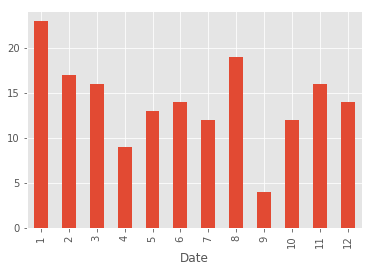

In [11]:
df['Name'].groupby(df.Date.dt.month).count().plot(kind="bar")

In [12]:
location_count = pd.DataFrame({'Count' : df.groupby( ['Location'] ).size()}).reset_index()
location_count

,Location,Count
0,Andrew's home,1
1,Dima's home,30
2,Father's home,4
3,Galina's home,2
4,Home,117
5,Kirill's home,3
6,Mirnoe,1
7,Renata's home,5
8,Syndicate pub,1
9,Train,5


In [13]:
players_count = pd.DataFrame({'Count' : df.groupby( ['Players'] ).size()}).reset_index()
players_count

,Players,Count
0,1,5
1,2,101
2,3,27
3,4,31
4,5,3
5,6,1
6,7,1


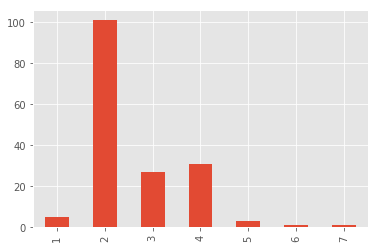

In [14]:
df.Players.value_counts().sort_index().plot(kind='bar')

In [27]:
df2 = get_gamedata(USER, '2016-01-01', '2016-12-31')
df3 = get_gamedata(USER, '2015-01-01', '2015-12-31')
df2['Length'] = df2['Length'].astype(int)
df3['Length'] = df3['Length'].astype(int)

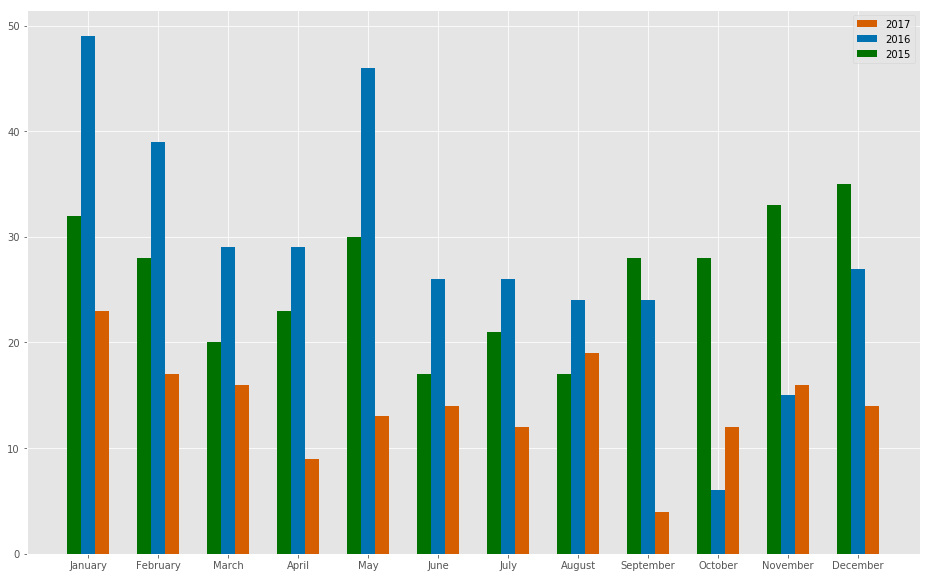

In [28]:
ind = np.arange(12)
width = 0.2

fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(111)

y1 = df['Name'].groupby(df.Date.dt.month).count()
y2 = df2['Name'].groupby(df2.Date.dt.month).count()
y3 = df3['Name'].groupby(df3.Date.dt.month).count()

bar1 = ax.bar(ind+width,y1,width,color="#D55E00",align='center')
bar2 = ax.bar(ind,y2,width,color="#0072B2",align='center')
bar3 = ax.bar(ind-width,y3,width,color="#007200",align='center')

ax.set_xticks(ind)
ax.set_xticklabels( [calendar.month_name[i] for i in range(1,13)] )
ax.legend( (bar1[0], bar2[0], bar3[0]), ('2017', '2016', '2015') )
plt.show()

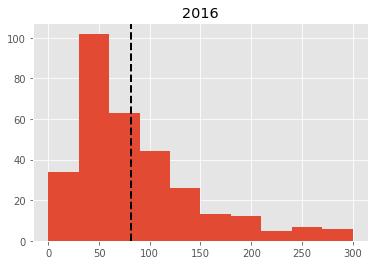

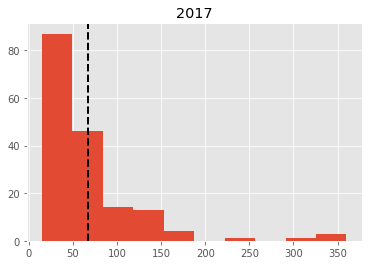

In [85]:
plt.figure(1)
plt.title('2016')
df3['Length'].hist()
plt.axvline(df3['Length'].mean(), color='k', linestyle='dashed', linewidth=2)

plt.figure(2)
plt.title('2017')
df['Length'].hist()
plt.axvline(df['Length'].mean(), color='k', linestyle='dashed', linewidth=2)


plt.show()

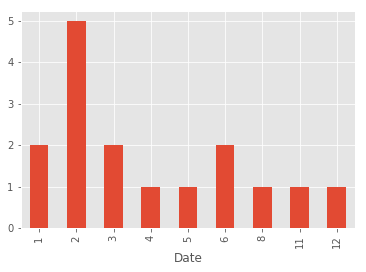

In [17]:
rtfg = df[(df.Name == 'Race for the Galaxy')]
rtfg['Name'].groupby(rtfg.Date.dt.month).count().plot(kind="bar")

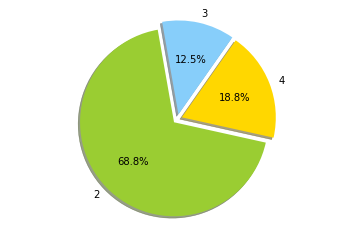

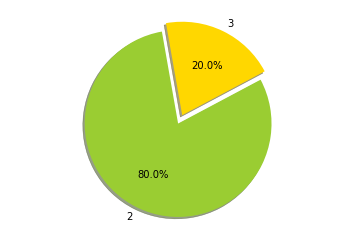

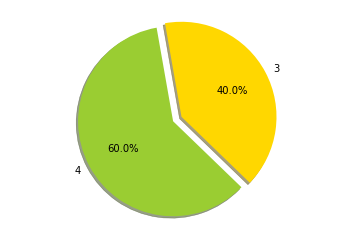

In [18]:
plt.figure(1)
game = df[(df.Name == 'Race for the Galaxy')]
labels = game.Players.value_counts().index.tolist()
players = game.Players.value_counts(normalize=True).tolist()
colors = ['yellowgreen', 'gold', 'lightskyblue']
explode = (0.05, 0.05, 0.05)

plt.pie(players, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=100)
plt.axis('equal')

plt.figure(2)
game = df[(df.Name == 'Bruges')]
labels = game.Players.value_counts().index.tolist()
players = game.Players.value_counts(normalize=True).tolist()
colors = ['yellowgreen', 'gold', 'lightskyblue']
explode = (0.05, 0.05)

plt.pie(players, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=100)
plt.axis('equal')

plt.figure(3)
game = df[(df.Name == 'Mysterium')]
labels = game.Players.value_counts().index.tolist()
players = game.Players.value_counts(normalize=True).tolist()
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral']
explode = (0.05, 0.05)

plt.pie(players, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=100)
plt.axis('equal')

plt.show()

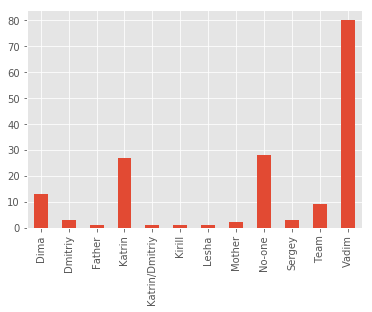

In [19]:
df.Winner.value_counts().sort_index().plot(kind='bar')

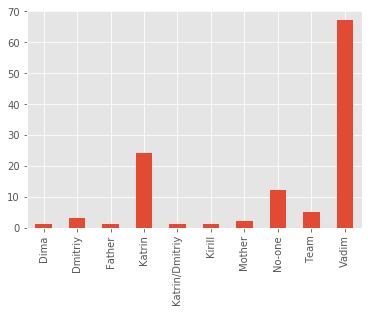

In [20]:
df[(df.Location == 'Home')].Winner.value_counts().sort_index().plot(kind='bar')

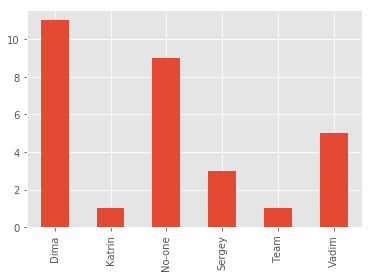

In [21]:
df[(df.Location == "Dima's home")].Winner.value_counts().sort_index().plot(kind='bar')